In [79]:
import glob
import os.path as osp
import random
import numpy as np
import json
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import models, transforms

In [80]:


import os
path = "/content/drive/MyDrive/python/deep_learning/PyTorch/models/"

files = os.listdir(path)
files

['before_fine']

In [81]:
# 乱シード設定
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

In [82]:
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benckmark = False

In [83]:
# 入力画像の前処理をするクラス
# 訓練時と推論時で処理が異なる


class ImageTransform():
    """
    画像の前処理クラス。訓練時、検証時で異なる動作をする。
    画像のサイズをリサイズし、色を標準化する。
    訓練時はRandomResizedCropとRandomHorizontalFlipでデータオーギュメンテーションする。


    Attributes
    ----------
    resize : int
        リサイズ先の画像の大きさ。
    mean : (R, G, B)
        各色チャネルの平均値。
    std : (R, G, B)
        各色チャネルの標準偏差。
    """

    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(
                    resize, scale=(0.5, 1.0)),  # データオーギュメンテーション
                transforms.RandomHorizontalFlip(),  # データオーギュメンテーション
                transforms.ToTensor(),  # テンソルに変換
                transforms.Normalize(mean, std)  # 標準化
            ]),
            'val': transforms.Compose([
                transforms.Resize(resize),  # リサイズ
                transforms.CenterCrop(resize),  # 画像中央をresize×resizeで切り取り
                transforms.ToTensor(),  # テンソルに変換
                transforms.Normalize(mean, std)  # 標準化
            ])
        }

    def __call__(self, img, phase='train'):
        """
        Parameters
        ----------
        phase : 'train' or 'val'
            前処理のモードを指定。
        """
        return self.data_transform[phase](img)

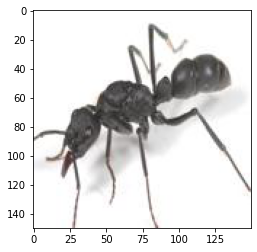

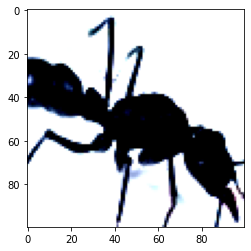

In [84]:
# 訓練時の画像前処理の動作を確認
# 実行するたびに処理結果の画像が変わる

imgae_file_path = 'drive/MyDrive/python/deep_learning/PyTorch/img_data/train/ants/000001_r.jpg'
img = Image.open(imgae_file_path)

plt.imshow(img)
plt.show()

# GPU使う場合
cuda = 1

if cuda == 1:
  size = 100 # 2242
else:
  size = 100


mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)



transform = ImageTransform(size, mean, std)
img_transformed = transform(img, phase="train")

img_transformed = img_transformed.numpy().transpose((1, 2, 0))
img_transformed = np.clip(img_transformed, 0, 1)
plt.imshow(img_transformed)
plt.show()

In [85]:
# アリとハチの画像へのファイルパスのリスト作成する

def make_datapath_list(phase):
    rootpath = "drive/MyDrive/python/deep_learning/PyTorch/img_data/"
    target_path = osp.join(rootpath+phase+'/*/*.jpg')
    
    path_list = []
    
    for path in glob.glob(target_path):
        path_list.append(path)
        
    return path_list

train_list = make_datapath_list(phase="train")
val_list = make_datapath_list(phase="val")

len(train_list)

100

In [86]:
# アリとハチの画像のDatasetを作成する


class HymenopteraDataset(data.Dataset):
    """
    アリとハチの画像のDatasetクラス。PyTorchのDatasetクラスを継承。

    Attributes
    ----------
    file_list : リスト
        画像のパスを格納したリスト
    transform : object
        前処理クラスのインスタンス
    phase : 'train' or 'test'
        学習か訓練かを設定する。
    """

    def __init__(self, file_list, transform=None, phase='train'):
        self.file_list = file_list  # ファイルパスのリスト
        self.transform = transform  # 前処理クラスのインスタンス
        self.phase = phase  # train or valの指定

    def __len__(self):
        '''画像の枚数を返す'''
        return len(self.file_list)

    def __getitem__(self, index):
        '''
        前処理をした画像のTensor形式のデータとラベルを取得
        '''

        # index番目の画像をロード
        img_path = self.file_list[index]
        img = Image.open(img_path).convert('RGB') # [高さ][幅][色RGB]

        # 画像の前処理を実施
        img_transformed = self.transform(
            img, self.phase)  # torch.Size([3, 224, 224])

        # 画像のラベルをファイル名から抜き出す
        if self.phase == "train":
            label = img_path[58:62]
        elif self.phase == "val":
            label = img_path[56:60]

        # ラベルを数値に変更する
        if label == "ants":
            label = 0
        elif label == "hati":
            label = 1

        return img_transformed, label


# 実行
train_dataset = HymenopteraDataset(
    file_list=train_list, transform=ImageTransform(size, mean, std), phase='train')

val_dataset = HymenopteraDataset(
    file_list=val_list, transform=ImageTransform(size, mean, std), phase='val')

# 動作確認
index = 0
print(train_dataset.__getitem__(index)[0].size())
print(train_dataset.__getitem__(index)[1])
print(len(train_dataset))
# print(val_dataset.__getitem__(index)[0].size())
# print(val_dataset.__getitem__(index)[1])
# train_dataset.__getitem__(index)[0].size()

torch.Size([3, 100, 100])
1
100


In [87]:
# ミニバッチのサイズを指定
batch_size = 20

# DataLoaderを作成
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False)

# 辞書型変数にまとめる
dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

# 動作確認
batch_iterator = iter(dataloaders_dict["train"])  # イテレータに変換
print(batch_iterator)
inputs, labels = next(
    batch_iterator)  # 1番目の要素を取り出す
print(inputs.size())
print(labels)

torch.Size([20, 3, 100, 100])
tensor([0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1])


In [88]:
# バッチサイズは全て一律の値でないと、モデル学習時に値が一致してなくエラーとなる
# バッチサイズが一致してるか確認
for i in train_dataloader:
  print(i[1].size())

torch.Size([20])
torch.Size([20])
torch.Size([20])
torch.Size([20])
torch.Size([20])


In [89]:
# ファインチューニング判別フラグ
fine_flag = 1

# モデル選択
model = "vgg16"

# 最後の出力層の出力ユニットをアリとハチの2つに付け替える
out_feature = 2

In [90]:
use_pretrained = True  # 学習済みのパラメータを使用

# 転移学習で学習させるパラメータを、変数params_to_updateに格納する
params_to_update = []
params_to_update_1 = []
params_to_update_2 = []
params_to_update_3 = []


if model == "vgg16":
  # VGG-16モデルのインスタンスを生成  
  net = models.vgg16(pretrained=use_pretrained)
  net.classifier[6] = nn.Linear(in_features=4096, out_features=out_feature)
  # パラメータ名
  if fine_flag:
    update_param_names_1 = ["features"]
    update_param_names_2 = ["classifier.0.weight", "classifier.0.bias", "classifier.3.weight", "classifier.3.bias"]
    update_param_names_3 = ["classifier.6.weight", "classifier.6.bias"]
  else:
    update_param_names = ["classifier.6.weight", "classifier.6.bias"]
  # モデル保存先
  save_path = "/content/drive/MyDrive/python/deep_learning/PyTorch/models/vgg16_best_models.pth"
  print(net.classifier)
elif model == "resnet":
  # ResNet50モデルのインスタンスを生成
  net = models.resnet50(pretrained=use_pretrained)
  net.fc = nn.Linear(net.fc.in_features, out_feature)
  # パラメータ名
  if fine_flag:
    update_param_names_1 = ["conv1.weight", "bn1.weight", "bn1.bias"]
    update_param_names_2 = ["layer"]
    update_param_names_3 = ["fc.weight", "fc.bias"]
  else:
    update_param_names = ["fc.weight", "fc.bias"]
  # モデル保存先
  save_path = "/content/drive/MyDrive/python/deep_learning/PyTorch/models/resnet_best_models.pth"
  print(net.fc)
elif model == "efficientNet":
  # EfficientNetモデルのインスタンスを生成
  net = models.efficientnet_b7(pretrained=use_pretrained)
  net.classifier[1] = nn.Linear(in_features=2560, out_features=out_feature, bias=True)
  # パラメータ名
  if fine_flag:
    update_param_names_1 = ["features"]
    update_param_names_2 = ["classifier.1.weight", "classifier.1.bias"]
  else:
    update_param_names = ["classifier.1.weight", "classifier.1.bias"]
  # モデル保存先
  save_path = "/content/drive/MyDrive/python/deep_learning/PyTorch/models/efficientNet_best_models.pth"
  print(net.classifier[1])

# 訓練モードに設定
net.train()

print('ネットワーク設定完了：学習済みの重みをロードし、訓練モードに設定しました')

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=2, bias=True)
)
ネットワーク設定完了：学習済みの重みをロードし、訓練モードに設定しました


In [91]:
# 損失関数の設定
criterion = nn.CrossEntropyLoss()

fine_flag = 1

# 学習させるパラメータ以外は勾配計算をなくし、変化しないように設定
if fine_flag:
  for name, param in net.named_parameters():
    if update_param_names_1[0] in name and (model == "vgg16" or model == "efficientNet"):
        param.requires_grad = True
        params_to_update_1.append(param)
        print("params_to_update_1に格納", name)

    elif name in update_param_names_1 and (model == "resnet"):
        param.requires_grad = True
        params_to_update_1.append(param)
        print("params_to_update_1に格納", name)

    elif name in update_param_names_2 and (model == "vgg16" or model == "efficientNet"):
        param.requires_grad = True
        params_to_update_2.append(param)
        print("params_to_update_2に格納", name)

    elif update_param_names_2[0] in name and (model == "resnet"):
        param.requires_grad = True
        params_to_update_2.append(param)
        print("params_to_update_2に格納", name)

    elif name in update_param_names_3 and (model == "vgg16" or model == "resnet"):
        param.requires_grad = True
        params_to_update_3.append(param)
        print("params_to_update_3に格納", name)
    else:
        param.requires_grad = False

else:
  for name, param in net.named_parameters():
    if name in update_param_names:
        param.requires_grad = True
        params_to_update.append(param)
        print(name)
    else:
        param.requires_grad = False

# params_to_updateの中身を確認
# print("-----------")
# print(params_to_update)

params_to_update_1に格納 features.0.weight
params_to_update_1に格納 features.0.bias
params_to_update_1に格納 features.2.weight
params_to_update_1に格納 features.2.bias
params_to_update_1に格納 features.5.weight
params_to_update_1に格納 features.5.bias
params_to_update_1に格納 features.7.weight
params_to_update_1に格納 features.7.bias
params_to_update_1に格納 features.10.weight
params_to_update_1に格納 features.10.bias
params_to_update_1に格納 features.12.weight
params_to_update_1に格納 features.12.bias
params_to_update_1に格納 features.14.weight
params_to_update_1に格納 features.14.bias
params_to_update_1に格納 features.17.weight
params_to_update_1に格納 features.17.bias
params_to_update_1に格納 features.19.weight
params_to_update_1に格納 features.19.bias
params_to_update_1に格納 features.21.weight
params_to_update_1に格納 features.21.bias
params_to_update_1に格納 features.24.weight
params_to_update_1に格納 features.24.bias
params_to_update_1に格納 features.26.weight
params_to_update_1に格納 features.26.bias
params_to_update_1に格納 features.28.weight
params_

In [92]:
if model == "vgg16":
  params = [
      {'params': params_to_update_1, 'lr': 1e-4},
      {'params': params_to_update_2, 'lr': 5e-4},
      {'params': params_to_update_3, 'lr': 1e-3}
  ]

elif model == "resnet":
  params = [
      {'params': params_to_update_1, 'lr': 1e-4},
      {'params': params_to_update_2, 'lr': 5e-4},
      {'params': params_to_update_3, 'lr': 1e-3}
  ]
elif model == "efficientNet":
  params = [
      {'params': params_to_update_1, 'lr': 1e-4},
      {'params': params_to_update_2, 'lr': 1e-3}
  ]

In [93]:
# 最適化手法の設定
# optimizer = optim.SGD(params=params_to_update, lr=0.001, momentum=0.9)
# optimizer = optim.Adadelta(params=params_to_update, lr=1.0, rho=0.95)
# optimizer = optim.Adam(params=params_to_update, lr=0.001, amsgrad=False)


optimizer = optim.Adam(params, amsgrad=False)

### 学習メモ

- vgg16が精度が良い
- optimizerはSGDの方がなぜか良い?
 - 調べても、Adadeltaの方が精度的にはいいはずなのに
 - パラメータ値の設定などを見直す

In [94]:
# モデルを学習させる関数を作成

def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):


    # 初期設定
    # GPUが使えるかを確認
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("使用デバイス：", device)

    # ネットワークをGPUへ
    net.to(device)

    # ネットワークがある程度固定であれば、高速化させる
    torch.backends.cudnn.benchmark = True

    all_epoch_acc = []  # 正解率リストに保存
    count = 0

    # epochのループ
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-------------')

        # epochごとの学習と検証のループ
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()  # モデルを訓練モードに
            else:
                net.eval()   # モデルを検証モードに

            epoch_loss = 0.0  # epochの損失和
            epoch_corrects = 0  # epochの正解数
            

            # 未学習時の検証性能を確かめるため、epoch=0の訓練は省略
            if (epoch == 0) and (phase == 'train'):
                continue

            # データローダーからミニバッチを取り出すループ
            for inputs, labels in tqdm(dataloaders_dict[phase]):

                # GPUが使えるならGPUにデータを送る
                inputs = inputs.to(device)
                labels = labels.to(device)

                # optimizerを初期化
                optimizer.zero_grad()

                # 順伝搬（forward）計算
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(inputs)
                    loss = criterion(outputs, labels)  # 損失を計算
                    _, preds = torch.max(outputs, 1)  # ラベルを予測
                  
                    # 訓練時はバックプロパゲーション
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    # 更新前のlossを保持
                    before_epoch_loss = epoch_loss

                    # イタレーション結果の計算
                    # lossの合計を更新
                    epoch_loss += loss.item() * inputs.size(0)  
                    # 正解数の合計を更新
                    epoch_corrects += torch.sum(preds == labels.data)
                    

            # epochごとのlossと正解率を表示
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloaders_dict[phase].dataset)
            # 更新前のepochごとのlossと正解率を表示
            before_epoch_loss = before_epoch_loss / len(dataloaders_dict[phase].dataset)
            # 検証の正解率を保持
            if phase == "val":
              all_epoch_acc.append(format(epoch_acc, '.4f'))
              count += 1

            if count-1 != 0 and phase == "val":
              # 一番良いモデルを保存
              if format(epoch_acc, '.4f') > max(all_epoch_acc[:-1]):
                
                torch.save(net.state_dict(), save_path)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
    print("max_num: ", max(all_epoch_acc))

In [95]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("使用デバイス：", device)

使用デバイス： cuda:0


In [96]:
!nvidia-smi

Sun Dec 18 07:04:53 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    29W /  70W |  15090MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [97]:
# 学習・検証を実行する
num_epochs=40
print("学習モデル:", model)
train_model(net, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

学習モデル: vgg16
使用デバイス： cuda:0


OutOfMemoryError: ignored

### adam使用した場合
- vgg16⇒0.8750
- resnet⇒0.8125
- efficientNet⇒0.8542

### ファインチューニングかつadamの場合
- GPUのメモリ容量が少なくて実行できない(24GIB以上は必要)
- vgg16⇒
- resnet⇒
- efficientNet⇒

In [17]:
# やること

# 学習率をグラフ化にする
# テストデータで解析かける

In [21]:
print(11 % 4)
print(11 % 2)

3
1


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
